In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

In [2]:
train_dir = '../input/intel-image-classification/seg_train/seg_train'
val_dir   = '../input/intel-image-classification/seg_test/seg_test'

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=128,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=128,
        class_mode='categorical', shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [6]:
class_indices = train_generator.class_indices
labels =dict((v,k) for k,v in class_indices.items())
labels

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [7]:
x, y = train_generator.next()
print('shape of image batch: ', x.shape)
print('shape of label batch: ', y.shape )


shape of image batch:  (128, 150, 150, 3)
shape of label batch:  (128, 6)


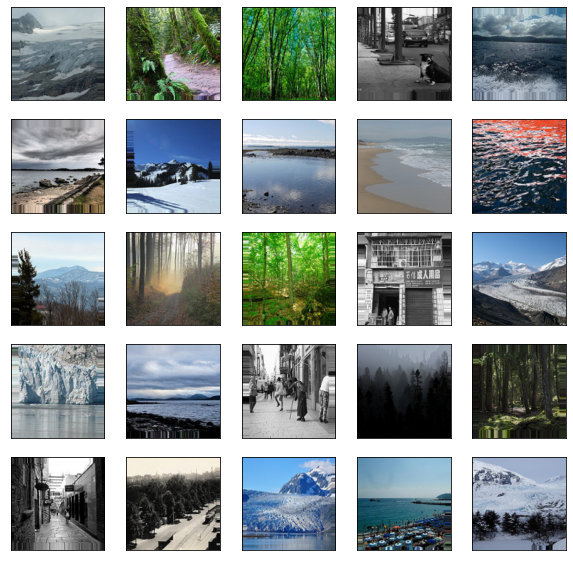

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i], cmap=plt.cm.binary)
    #plt.xlabel(labels[y[i]])
plt.show()

In [9]:
conv_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))

9412608/9406464 [==============================] - 0s 0us/step


In [10]:
model = tf.keras.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 2,231,558
Non-trainable params: 34,112
_________________________________________________________________


In [11]:
#compile model
model.compile(optimizer= optimizers.SGD(lr=0.0001), loss= 'categorical_crossentropy', metrics=['acc'])

In [12]:
#fit model
steps = train_generator.samples/train_generator.batch_size
history = model.fit_generator(train_generator,steps_per_epoch=steps, epochs=20, validation_data=validation_generator, validation_steps=1, max_queue_size = 265, workers = 4)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
109/109 [==============================] - 101s 816ms/step - loss: 2.2046 - acc: 0.1740 - val_loss: 3.4676 - val_acc: 0.0234
Epoch 2/20
109/109 [==============================] - 85s 740ms/step - loss: 1.8989 - acc: 0.2510 - val_loss: 2.7837 - val_acc: 0.0859
Epoch 3/20
109/109 [==============================] - 86s 747ms/step - loss: 1.6791 - acc: 0.3273 - val_loss: 2.2694 - val_acc: 0.1953
Epoch 4/20
109/109 [==============================] - 85s 742ms/step - loss: 1.4925 - acc: 0.4239 - val_loss: 1.8772 - val_acc: 0.2969
Epoch 5/20
109/109 [==============================] - 86s 741ms/step - loss: 1.3553 - acc: 0.4919 - val_loss: 1.5762 - val_acc: 0.4219
Epoch 6/20
109/109 [==============================] - 86s 749ms/step - loss: 1.2289 - acc: 0.5549 - val_loss: 1.3459 - val_acc: 0.5000
Epoch 7/20
109/109 [==============================] - 85s 743ms/step - loss: 1.1393 - acc: 0.6013 - val_loss: 1.1591 - val_acc: 0.5781
Epoch 8/20
109/109 [==============================] - 

In [13]:
model.save('intel_image_classifier_mobilenetv2_acc_0.81_valAcc_0.87.h5')

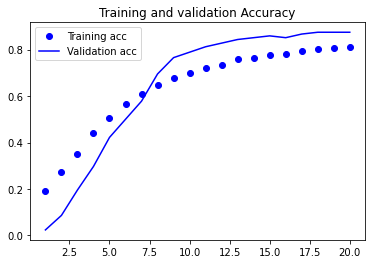

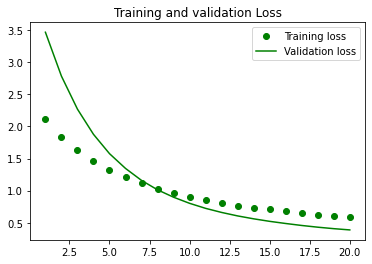

In [14]:
#plot acc loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend()

plt.show()

In [15]:
predict = model.predict_generator(validation_generator, max_queue_size=256, workers=2)
predict_y = np.argmax(predict, axis=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [16]:
#classification_report
class_labels = list(validation_generator.class_indices.keys()) 
cls_report = classification_report(validation_generator.classes, predict_y, target_names=class_labels)
print(cls_report)

              precision    recall  f1-score   support

   buildings       0.78      0.88      0.82       437
      forest       0.91      0.95      0.93       474
     glacier       0.76      0.67      0.71       553
    mountain       0.64      0.83      0.72       525
         sea       0.88      0.75      0.81       510
      street       0.90      0.73      0.80       501

    accuracy                           0.80      3000
   macro avg       0.81      0.80      0.80      3000
weighted avg       0.81      0.80      0.80      3000



In [17]:
def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,title=None,cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
   
    # Only use the labels that appear in the data
   
    classes = list(map(lambda x: classes[x], unique_labels(y_true, y_pred)))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix


<AxesSubplot:title={'center':'Confusion matrix, with normalization'}, xlabel='Predicted label', ylabel='True label'>

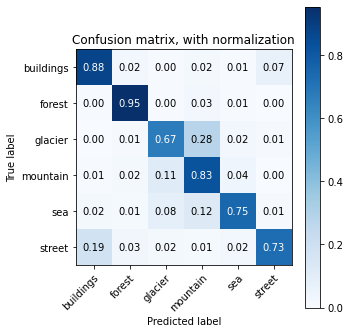

In [18]:
plot_confusion_matrix(validation_generator.classes, predict_y, classes=class_labels,normalize=True,title='Confusion matrix, with normalization')

In [19]:
results = model.evaluate(validation_generator, batch_size=256)
print("validation loss, validation acc:", results)

24/24 [==============================] - 6s 240ms/step - loss: 0.5973 - acc: 0.7963
validation loss, validation acc: [0.5973314046859741, 0.7963333129882812]
